# Adversarial Patches
### Sizhe Chen

In [5]:
import os
import math
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torchvision import transforms, models
import torchvision.transforms.functional as TF

# “No AI tools were used for this chunck

In [6]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# “No AI tools were used for this chunck

Using device: cpu


In [42]:
from torchvision import models, transforms

model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device)
model.eval()


# “No AI tools were used for this chunck

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [43]:
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device).eval()

# Define ImageNet normalization manually
preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Define mean/std tensors for denormalization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

# The above code snippet was generated using ChatGPT 5 on 11/1/25 at 8:07am and 
# then modified in order to use the non-deprecated weights argument (models.ResNet34_Weights.IMAGENET1K_V1).

def denormalize(tensor):
    """Convert normalized tensor -> [0,1]"""
    t = tensor.clone().cpu()
    t = t * std + mean
    return torch.clamp(t, 0, 1)


def show_tensor(tensor, title=None):
    """Quick helper to show a tensor image"""
    img = TF.to_pil_image(denormalize(tensor))
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()




In [45]:
from glob import glob

image_folder = "data/images" 
os.makedirs(image_folder, exist_ok=True)

image_paths = sorted(glob(os.path.join(image_folder, "*.*")))
print("Found images:", len(image_paths))
# No AI tools were used for this chunk

Found images: 5


In [46]:
def place_patch_on_image(img_tensor, patch_tensor, x, y):
    """
    img_tensor: C x H x W in [0,1]
    patch_tensor: C x ph x pw in [0,1]
    place so patch covers [y:y+ph, x:x+pw]
    returns patched image tensor (C x H x W)
    """
    img = img_tensor.clone()
    _, H, W = img.shape
    _, ph, pw = patch_tensor.shape
    if pw > W or ph > H:
        patch_tensor = TF.resize(patch_tensor, [min(ph, H), min(pw, W)])
        _, ph, pw = patch_tensor.shape
    img[:, y : y + ph, x : x + pw] = patch_tensor
    return img


def random_place_coords(img, patch):
    _, H, W = img.shape
    _, ph, pw = patch.shape
    max_x = max(0, W - pw)
    max_y = max(0, H - ph)
    x = random.randint(0, max_x)
    y = random.randint(0, max_y)
    return x, y


def augment_image_and_patch(img, patch):
    """applies random brightness/contrast and random placement & small rotation/scale to patch"""
    
    ph, pw = patch.shape[1], patch.shape[2]
    scale = random.uniform(0.85, 1.15)
    new_ph = max(1, int(ph * scale))
    new_pw = max(1, int(pw * scale))
    p = TF.resize(patch, [new_ph, new_pw])
    angle = random.uniform(-15, 15)
    p = TF.rotate(p, angle)
    x, y = random_place_coords(img, p)
    img_aug = TF.adjust_brightness(img, random.uniform(0.9, 1.1))
    img_aug = TF.adjust_contrast(img_aug, random.uniform(0.9, 1.1))
    out = place_patch_on_image(img_aug, p, x, y)
    return out
# No AI tools were used for this chunk

In [47]:
patch_size_pixels = 160  
num_epochs = 400
lr = 0.3
steps_per_epoch = max(1, len(images_list))  
tv_weight = 1e-3

patch_logits = torch.randn(
    3, patch_size_pixels, patch_size_pixels, device=device, requires_grad=True
)
optimizer = torch.optim.Adam([patch_logits], lr=lr)

target = target_idx

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i in range(steps_per_epoch):
        img = images_list[i % len(images_list)].to(device)  
        optimizer.zero_grad()
        patch = torch.sigmoid(patch_logits)  # 0..1
        patched_img = augment_image_and_patch(img, patch)  
        pil = TF.to_pil_image(patched_img.cpu())
        inp = preprocess(pil).unsqueeze(0).to(device) 
        out = model(inp)  
        probs = F.softmax(out, dim=1)[0]
        loss_target = -torch.log(probs[target] + 1e-8)
        tv = torch.sum(torch.abs(patch[:, :, :-1] - patch[:, :, 1:])) + torch.sum(
            torch.abs(patch[:, :-1, :] - patch[:, 1:, :])
        )
        loss = loss_target + tv_weight * tv
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch + 1) % 10 == 0 or epoch == 0:
        with torch.no_grad():
            # quick evaluation on first image
            patch = torch.sigmoid(patch_logits)
            sample_pat_img = augment_image_and_patch(images_list[0].to(device), patch)
            inp = (
                preprocess(TF.to_pil_image(sample_pat_img.cpu()))
                .unsqueeze(0)
                .to(device)
            )
            out = model(inp)
            probs = F.softmax(out, dim=1)[0]
            top5 = torch.topk(probs, 5)
            print(
                f"Epoch {epoch+1}/{num_epochs} avg_loss={epoch_loss/steps_per_epoch:.3f} top1={classes[top5.indices[0]]} prob={top5.values[0]:.3f}"
            )
# No AI tools were used for this chunk

Epoch 1/400 avg_loss=35.195 top1=tiger cat prob=0.828
Epoch 10/400 avg_loss=13.053 top1=tiger cat prob=0.717
Epoch 20/400 avg_loss=13.282 top1=tiger cat prob=0.832
Epoch 30/400 avg_loss=13.880 top1=tiger cat prob=0.941
Epoch 40/400 avg_loss=13.330 top1=tiger cat prob=0.800
Epoch 50/400 avg_loss=14.182 top1=tiger cat prob=0.870
Epoch 60/400 avg_loss=13.643 top1=tiger cat prob=0.729
Epoch 70/400 avg_loss=13.238 top1=tiger cat prob=0.804
Epoch 80/400 avg_loss=13.321 top1=tiger cat prob=0.907
Epoch 90/400 avg_loss=13.725 top1=tiger cat prob=0.786
Epoch 100/400 avg_loss=13.960 top1=tiger cat prob=0.542
Epoch 110/400 avg_loss=12.956 top1=tiger cat prob=0.736
Epoch 120/400 avg_loss=14.698 top1=tiger cat prob=0.721
Epoch 130/400 avg_loss=13.860 top1=tiger cat prob=0.820
Epoch 140/400 avg_loss=13.535 top1=tiger cat prob=0.812
Epoch 150/400 avg_loss=13.851 top1=tiger cat prob=0.699
Epoch 160/400 avg_loss=14.158 top1=tiger cat prob=0.713
Epoch 170/400 avg_loss=14.586 top1=tiger cat prob=0.838
Epo

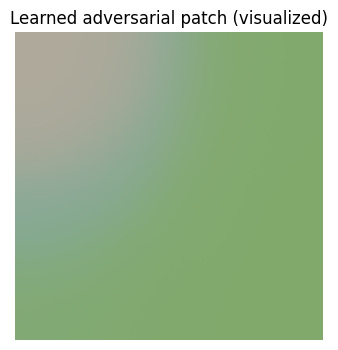

Saved patch to learned_patch.png


In [50]:
with torch.no_grad():
    learned_patch = torch.sigmoid(patch_logits).cpu()  # C x ph x pw in [0,1]
    show_tensor(learned_patch, title="Learned adversarial patch (visualized)")

    
    pil_patch = TF.to_pil_image(learned_patch)
    save_path = "learned_patch.png"
    pil_patch.save(save_path)
    print("Saved patch to", save_path)
# No AI tools were used for this chunk

In [51]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import models
from torchvision.models import ResNet34_Weights

weights = ResNet34_Weights.IMAGENET1K_V1
model = models.resnet34(weights=weights).eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

target_name = "bubble"
with open("imagenet_classes.txt") as f:
    classes = [line.strip() for line in f.readlines()]
target_idx = classes.index(target_name)
print("Target class index:", target_idx)

patch = torch.rand(1, 3, 224, 224, requires_grad=True, device=device)
optimizer = torch.optim.Adam([patch], lr=0.1)

num_epochs = 2000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    inp = patch.clamp(0, 1)
    out = model(inp)
    probs = F.softmax(out, dim=1).squeeze(0)
    loss = -torch.log(probs[target_idx] + 1e-8)
    loss.backward()
    optimizer.step()

    if epoch == 1000:
        for g in optimizer.param_groups:
            g["lr"] *= 0.3

    if (epoch + 1) % 100 == 0:
        top5 = torch.topk(probs, 5)
        top1_idx = top5.indices[0].item()
        top1_prob = top5.values[0].item()
        print(
            f"Epoch {epoch+1}/{num_epochs}: loss={loss.item():.3f}, "
            f"top1={classes[top1_idx]}, prob={top1_prob:.3f}"
        )

from torchvision.utils import save_image

final_patch = patch.detach().clamp(0, 1)[0]
save_image(final_patch, "direct_bubble_patch.png")
# No AI tools were used for this chunk

Target class index: 971
Epoch 100/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 200/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 300/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 400/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 500/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 600/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 700/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 800/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 900/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 1000/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 1100/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 1200/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 1300/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 1400/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 1500/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 1600/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 1700/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 1800/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 1900/2000: loss=0.000, to

# combine two patches

canonical patch size: (160, 160)


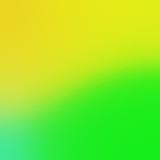

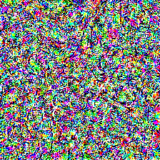

In [39]:
from PIL import Image, ImageOps
import numpy as np
import torch
import torchvision.transforms.functional as TF

def load_learned_patch_as_pil(target_size=None):
    try:
        learned_patch 
        t = learned_patch.detach().cpu()
        if t.ndim == 4:
            t = t[0]
        pil = TF.to_pil_image(t.clamp(0, 1))
        if target_size:
            pil = pil.resize(target_size, Image.BILINEAR)
        return pil
    except NameError:
        for fname in "learned_patch.png":
            try:
                pil = Image.open(fname).convert("RGB")
                if target_size:
                    pil = pil.resize(target_size, Image.BILINEAR)
                return pil
            except FileNotFoundError:
                continue
        raise FileNotFoundError(
            "learned_patch not found in memory or on disk (looked for learned_patch.png)."
        )

def load_direct_patch_as_pil(target_size=None):
    candidates = ["direct_toaster_patch.png"]
    for fname in candidates:
        try:
            pil = Image.open(fname).convert("RGB")
            if target_size:
                pil = pil.resize(target_size, Image.BILINEAR)
            return pil
        except FileNotFoundError:
            continue
    raise FileNotFoundError("direct_toaster_patch.* not found in cwd. Check file name.")



try:
    if "learned_patch" in globals():
        t = learned_patch.detach().cpu()
        if t.ndim == 4:
            t = t[0]
        H, W = int(t.shape[1]), int(t.shape[2])
        canon = (W, H)
except Exception:
    pass

if canon is None:
    canon = (224, 224)

print("canonical patch size:", canon)

learned_pil = load_learned_patch_as_pil(target_size=canon)
direct_pil = load_direct_patch_as_pil(target_size=canon)

display(learned_pil)
display(direct_pil)
# No AI tools were used for this chunk

Saved: combined_blend_50.png


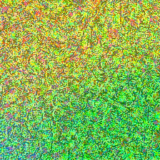

Saved: combined_toaster70.png


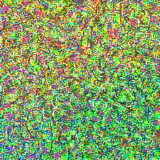

Saved: combined_half_lr.png


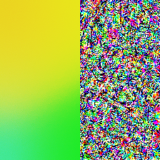

Saved: combined_checker.png


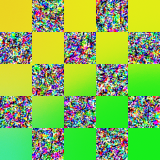

Saved: combined_multiply.png


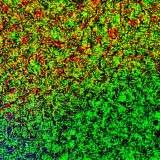

In [40]:
def save_and_show(pil, name):
    pil.save(name)
    print("Saved:", name)
    display(pil)


W, H = canon

# 1) Weighted alpha blend (50/50)
alpha = 0.5
blend_50 = Image.blend(learned_pil, direct_pil, alpha)
save_and_show(blend_50, "combined_blend_50.png")

# 2) Strong toaster-dominant (70% toaster)
blend_toaster70 = Image.blend(learned_pil, direct_pil, 0.7)
save_and_show(blend_toaster70, "combined_toaster70.png")

# 3) Left half learned, right half toaster
half = Image.new("RGB", (W, H))
left = learned_pil.crop((0, 0, W // 2, H))
right = direct_pil.crop((W // 2, 0, W, H))
half.paste(left, (0, 0))
half.paste(right, (W // 2, 0))
save_and_show(half, "combined_half_lr.png")

# 4) Checkerboard mix 
checker = Image.new("RGB", (W, H))
box = 32  
for y in range(0, H, box):
    for x in range(0, W, box):
        use = learned_pil if ((x // box + y // box) % 2 == 0) else direct_pil
        tile = use.crop((x, y, min(x + box, W), min(y + box, H)))
        checker.paste(tile, (x, y))
save_and_show(checker, "combined_checker.png")

# 5) Multiply blend 
np_a = np.array(learned_pil).astype(np.float32) / 255.0
np_b = np.array(direct_pil).astype(np.float32) / 255.0
np_mul = np_a * np_b
mul_pil = Image.fromarray(np.uint8(np.clip(np_mul * 255.0, 0, 255)))
save_and_show(mul_pil, "combined_multiply.png")
# No AI tools were used for this chunk